In [98]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from cmcrameri import cm as cmc
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from shapely.geometry import shape
from shapely.geometry.polygon import orient
from shapely import wkt
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import features
from rasterio.features import shapes
from IPython.display import Image, display
import contextily as cx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
gdf_names = gpd.read_file('basins/shapefiles/GRE_fullnames_GIMP_merged.shp')
gdf_basins = gpd.read_file('basins/shapefiles/GRE_basins_merged_GRIMP.shp')
gdf_merged = gpd.read_file('basins/shapefiles/GRE_basins_merged_GRIMP.shp') 

df = pd.read_csv('GLD3_GrIS_lakestats.csv')
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, crs='EPSG:3413')
gdfg = gdf[gdf.label=='good_lake']

figdir = 'plots_GrIS/'

# Stats by melt season, basin, glacier type, etc...

In [100]:
def calc_group_stats(groupby):
    group_all = gdf.groupby(groupby)
    group_good = gdfg.groupby(groupby)
    counts = group_all[['lake_id']].count().rename(columns={'lake_id': 'number_lakes'})
    maxd = group_good[['max_depth']].max()
    medianstats = ['total_length', 'surface_elevation', 'depth_quality_sort', 'max_depth', 'depth_median']
    meds = group_good[medianstats].median().rename(columns={k: 'median_'+k for k in medianstats})
    dfout = pd.concat((counts,maxd,meds), axis=1)
    return dfout
    
def stats_from_groups(groups, show=True):
    stat_list = []
    for groupby in groups:
        df = calc_group_stats(groupby)
        stat_list.append(df)
        if show:
            display(df)
    return pd.concat(stat_list, keys=groups)

In [101]:
groups = ['label', 'basin', 'melt_season', 'glacier_type', ['basin', 'melt_season'], 'beam_strength', 'beam_number']
stats_grouped = stats_from_groups(groups)

display(calc_group_stats('sub_basin').sort_values(by='number_lakes', ascending=False).iloc[:20])

,number_lakes,max_depth,median_total_length,median_surface_elevation,median_depth_quality_sort,median_max_depth,median_depth_median
label,,,,,,,
good_lake,7395,26.911765,415.0,1025.141041,1.819985,2.50447,1.641365
lake_bad_depth,1391,NaN,NaN,NaN,NaN,NaN,NaN


,number_lakes,max_depth,median_total_length,median_surface_elevation,median_depth_quality_sort,median_max_depth,median_depth_median
basin,,,,,,,
CE,422,21.149690,340.0,1412.673318,1.737941,2.928904,1.814314
CW,1178,23.901030,530.0,1209.302915,2.255710,3.000632,1.906653
NE,2189,26.911765,425.0,834.807502,1.599136,2.453826,1.643042
NO,1769,24.790158,365.0,796.942532,1.731991,2.195796,1.463482
NW,1413,26.078751,435.0,907.392461,2.081661,3.179341,2.050014
SE,46,11.824537,280.0,1301.800260,1.539039,3.976733,2.561707
SW,1769,23.382771,410.0,1401.768807,1.706326,2.094484,1.429966


,number_lakes,max_depth,median_total_length,median_surface_elevation,median_depth_quality_sort,median_max_depth,median_depth_median
melt_season,,,,,,,
2019,2132,26.911765,425.0,1116.623581,1.929324,2.501090,1.615850
2020,1673,22.221579,405.0,991.326302,1.891674,2.604804,1.668447
2021,1788,26.078751,400.0,1003.496429,1.938234,2.576826,1.728349
2022,1597,23.677998,395.0,947.096489,1.565609,2.461280,1.606008
2023,1596,22.485705,435.0,1044.197838,1.714837,2.389525,1.592333


,number_lakes,max_depth,median_total_length,median_surface_elevation,median_depth_quality_sort,median_max_depth,median_depth_median
glacier_type,,,,,,,
land_terminating,2275,23.382771,420.0,1300.129025,1.810468,2.072892,1.404789
tidewater,6511,26.911765,410.0,919.652666,1.821478,2.680592,1.744760


number_lakes  max_depth  median_total_length  \
basin melt_season                                                 
CE    2019                   93  14.243175                390.0   
      2020                   73  21.149690                290.0   
      2021                  132  17.612430                372.5   
      2022                   43  18.261885                235.0   
      2023                   81  12.632382                315.0   
CW    2019                  406  23.901030                600.0   
      2020                  190  16.119974                490.0   
      2021                  209  15.579437                457.5   
      2022                  217  18.145568                485.0   
      2023                  156  18.794083                575.0   
NE    2019                  619  26.911765                397.5   
      2020                  321  18.413040                400.0   
      2021                  439  22.991018                420.0   
      2022                  359  22.993522                455.0   
      2023                  451  22.485705                475.0   
NO    2019                  227  24.790158                365.0   
      2020                  392  18.664992                365.0   
      2021                  347  14.502900                365.0   
      2022                  390  20.450589                322.5   
      2023                  413  22.092163                420.0   
NW    2019                  311  25.238436                510.0   
      2020                  285  22.221579                417.5   
      2021                  293  26.078751                385.0   
      2022                  251  23.677998                382.5   
      2023                  273  21.425778                445.0   
SE    2019                    8   8.130929                270.0   
      2020                   10   7.556306                215.0   
      2021                   11  11.824537                405.0   
      2022                    7   4.756101                125.0   
      2023                   10   9.343841                350.0   
SW    2019                  468  20.132877                380.0   
      2020                  402  14.313199                410.0   
      2021                  357  13.335276                452.5   
      2022                  330  23.382771                420.0   
      2023                  212   9.293056                350.0   

                   median_surface_elevation  median_depth_quality_sort  \
basin melt_season                                                        
CE    2019                      1516.275263                   1.722089   
      2020                      1293.252207                   1.761631   
      2021                      1442.903581                   1.882762   
      2022                      1050.014394                   2.327698   
      2023                      1450.034389                   1.540320   
CW    2019                      1255.880050                   2.489178   
      2020                      1188.155416                   2.282280   
      2021                      1276.790378                   2.401624   
      2022                      1095.137299                   2.036532   
      2023                      1280.438080                   1.756996   
NE    2019                       840.351450                   1.892114   
      2020                       749.299136                   1.507885   
      2021                       833.016639                   1.646687   
      2022                       793.828048                   1.002921   
      2023                       960.069378                   1.929436   
NO    2019                       835.538169                   1.531787   
      2020                       790.688510                   1.811057   
      2021                       735.843978                   2.146500   
      2022                       785.313127                

,number_lakes,max_depth,median_total_length,median_surface_elevation,median_depth_quality_sort,median_max_depth,median_depth_median
beam_strength,,,,,,,
strong,4970,26.911765,400.0,1022.014313,1.837611,2.491720,1.666621
weak,3816,24.292042,435.0,1030.136304,1.787836,2.523913,1.604413


,number_lakes,max_depth,median_total_length,median_surface_elevation,median_depth_quality_sort,median_max_depth,median_depth_median
beam_number,,,,,,,
1,1503,25.238436,415.0,1005.934301,1.990585,2.644129,1.710521
2,1176,22.092163,445.0,995.508060,1.853431,2.650433,1.717972
3,1789,26.911765,395.0,1019.977257,1.670615,2.411284,1.609242
4,1403,24.292042,420.0,1042.704278,1.772319,2.420964,1.537724
5,1678,26.078751,395.0,1025.781544,1.820207,2.484563,1.663881
6,1237,23.677998,435.0,1033.682695,1.725530,2.480236,1.599080


TypeError: unhashable type: 'list'

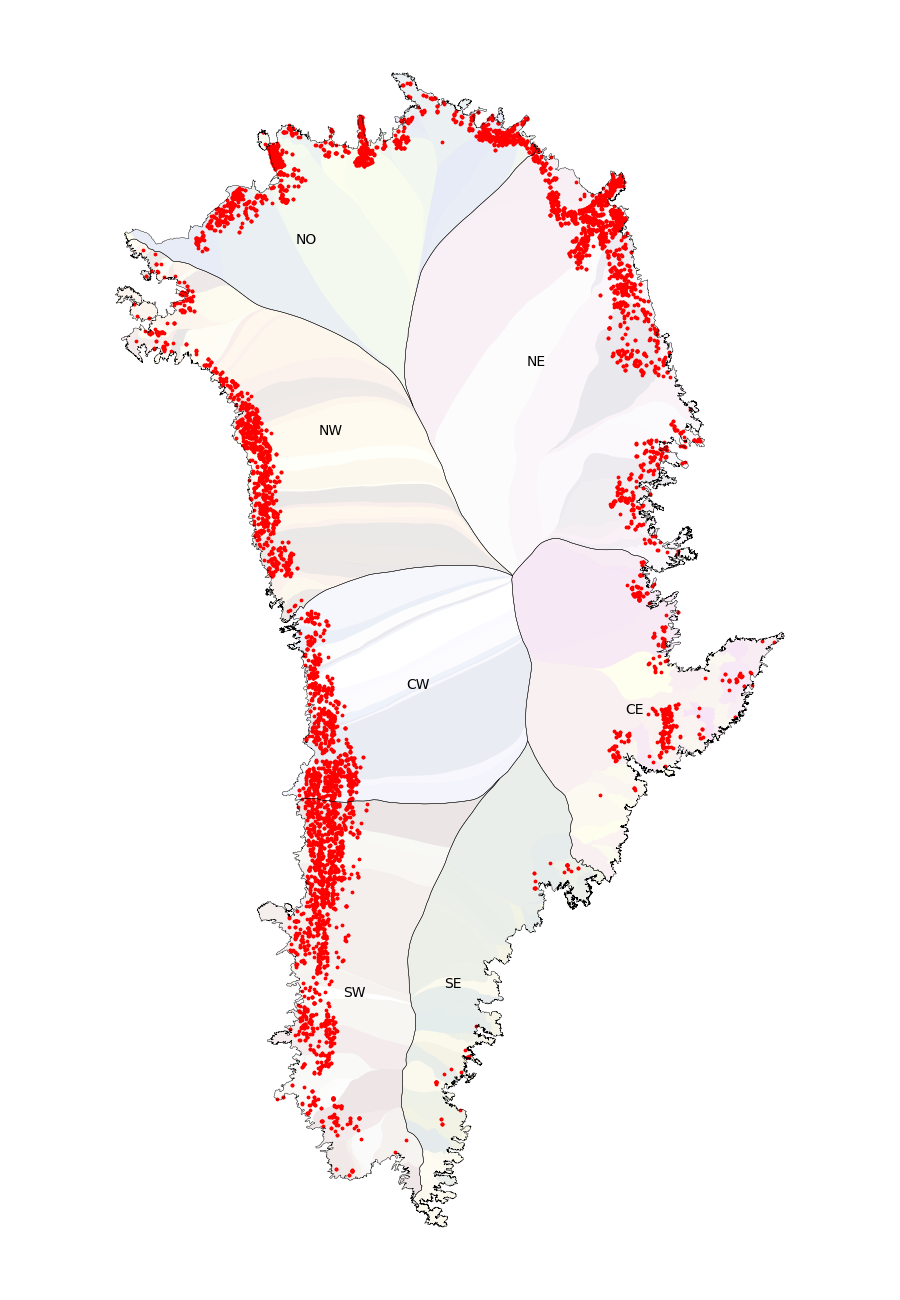

In [102]:
fig, ax = plt.subplots(figsize=[9,13])

crsp = 'EPSG:3413'
gdfnp = gdf_names.to_crs(crsp)
gdfp = gdf.to_crs(crsp)
gdfmp = gdf_merged.to_crs(crsp)

regcms = {
    'NO': cmc.imola,
    'NW': cmc.lajolla,
    'NE': cmc.acton, 
    'CW': cmc.devon,
    'CE': cmc.buda,
    'SW': cmc.bilbao,
    'SE': cmc.bamako
}
for i, sub in enumerate(np.unique(gdfnp.SUBREGION1)):
    gdf_sub = gdfnp[gdfnp.SUBREGION1 == sub]
    gdf_sub.plot(column='NAME', cmap=regcms[sub], ax=ax, alpha=0.1)

gdfmp.boundary.plot(color='k', ax=ax, lw=0.3)
gdfmp.apply(lambda x: ax.annotate(text=x['SUBREGION1'], xy=x.geometry.representative_point().coords[0], 
                                       ha='center',va='center',color='k',fontsize=10),axis=1)

gdfp.plot(ax=ax, markersize=3, color='r', alpha=1)

# cx.add_basemap(ax=ax, crs='EPSG:3413', source=cx.providers.CartoDB.Positron, zoom_adjust=0, attribution_size=6)

ax.axis('off')
fig.tight_layout()

fig.savefig(figdir+'z_prelim_all_lakes_map.jpg', dpi=300)

In [ ]:
GlacierLakeDetectionICESat2/sonar/bbox_shapefiles/Sonar_2022-07-04_lake610a_bbox_buff_87.shp
GlacierLakeDetectionICESat2/sonar/bbox_shapefiles/Sonar_2022-07-09_lake522_bbox_buff_101.shp
GlacierLakeDetectionICESat2/sonar/bbox_shapefiles/Sonar_2022-07-09_lake610b_bbox_buff_86.shp

In [166]:
import shutil
fn = 'sonar/bbox_shapefiles/Sonar_2022-07-04_lake610a_bbox_buff_1102.shp'
gdfs = gpd.read_file(fn).to_crs(gdfp.crs).buffer(1000)
gdfs.exterior.plot(ax=ax, color='C0')
lks_within = gdfp[gdfp.within(gdfs.geometry.iloc[0])]
lks_within

,lake_id,label,ice_sheet,melt_season,date_time,lon,lat,surface_elevation,depth_quality_sort,max_depth,...,conf_q90,length_water,total_length,depth_mean,depth_median,ratio_water,geometry,basin,sub_basin,glacier_type
3502,lake_099803_GrIS_2022_simplified_GRE_2200_NE_A...,good_lake,GrIS,2022,2022-08-16T10:47:25Z,-21.936378,78.902766,183.571476,1.968461,17.206128,...,0.729935,1355.0,1355.0,9.195672,7.989997,0.553623,POINT (472357.724 -1109378.459),NE,ZACHARIAE_ISSTROM,tidewater
3989,lake_099841_GrIS_2021_simplified_GRE_2200_NE_A...,good_lake,GrIS,2021,2021-07-25T15:52:00Z,-21.906806,78.900116,190.005661,1.591644,5.501512,...,0.604937,255.0,255.0,2.698559,2.430171,0.330935,POINT (473043.833 -1109400.916),NE,ZACHARIAE_ISSTROM,tidewater


../GLD3_complete/GrIS/detection_context/good_lake/lake_099803_GrIS_2022_simplified_GRE_2200_NE_ATL03_20220816104709_08481605_006_01_gt1r_0005_context.jpg
../GLD3_complete/GrIS/detection_out_data/good_lake/lake_099803_GrIS_2022_simplified_GRE_2200_NE_ATL03_20220816104709_08481605_006_01_gt1r_0005.h5
sonar/IS2/Sonar_2022-07-04_lake610a_099803_GrIS_2022_simplified_GRE_2200_NE_ATL03_20220816104709_08481605_006_01_gt1r_0005_context.jpg
sonar/IS2/Sonar_2022-07-04_lake610a_099803_GrIS_2022_simplified_GRE_2200_NE_ATL03_20220816104709_08481605_006_01_gt1r_0005.h5


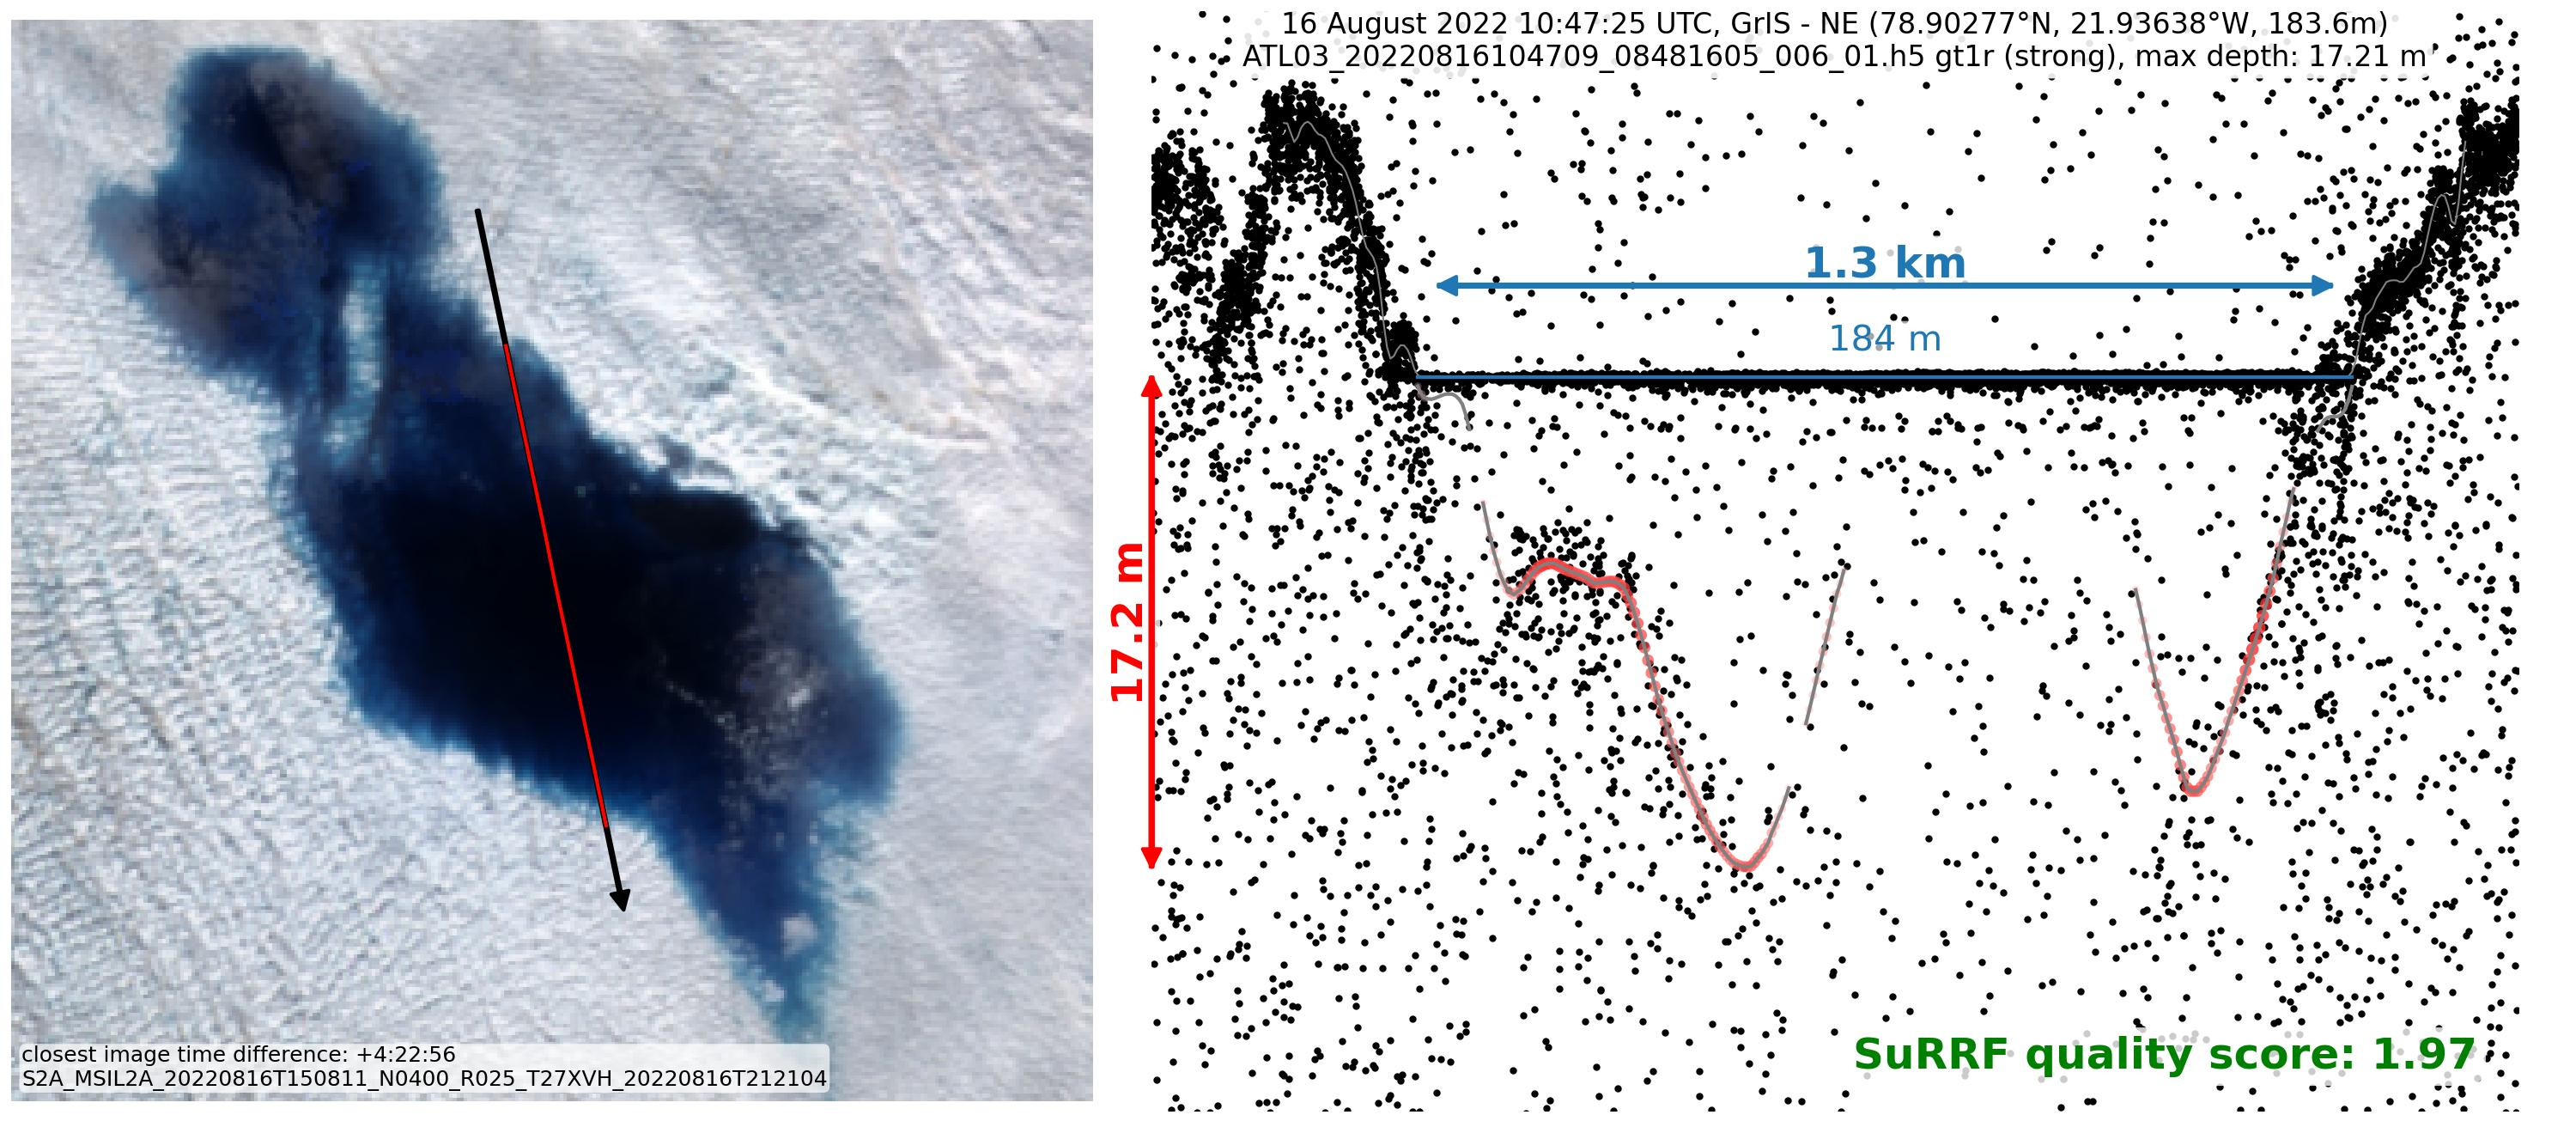

In [146]:
lk_sel = 3502
id = lks_within.loc[lk_sel].lake_id
label = lks_within.loc[lk_sel].label
fn_ql = '../GLD3_complete/GrIS/detection_context/%s/%s_context.jpg' % (label, id)
fn_h5 = '../GLD3_complete/GrIS/detection_out_data/%s/%s.h5' % (label, id)
print(fn_ql)
print(fn_h5)
path_out = 'sonar/IS2'
fn_ql_copy = path_out + fn_ql.split('/')[-1].replace('lake_','/%s_' % fn[fn.rfind('Sonar_'):fn.rfind('_bbox_')])
fn_h5_copy = path_out + fn_h5.split('/')[-1].replace('lake_','/%s_' % fn[fn.rfind('Sonar_'):fn.rfind('_bbox_')])
print(fn_ql_copy)
print(fn_h5_copy)
display(Image(fn_ql))
# shutil.copy(fn_ql, fn_ql_copy)
# shutil.copy(fn_h5, fn_h5_copy)

In [167]:
fn = 'sonar/bbox_shapefiles/Sonar_2022-07-09_lake522_bbox_buff_1290.shp'
gdfs = gpd.read_file(fn).to_crs(gdfp.crs).buffer(1000)
gdfs.exterior.plot(ax=ax, color='C1')
lks_within = gdfp[gdfp.within(gdfs.geometry.iloc[0])]
lks_within

,lake_id,label,ice_sheet,melt_season,date_time,lon,lat,surface_elevation,depth_quality_sort,max_depth,...,conf_q90,length_water,total_length,depth_mean,depth_median,ratio_water,geometry,basin,sub_basin,glacier_type
1277,lake_099372_GrIS_2019_simplified_GRE_2200_NE_A...,good_lake,GrIS,2019,2019-06-21T17:45:22Z,-21.802226,78.925955,205.923293,6.275333,8.244040,...,0.910490,870.0,870.0,4.369849,4.496133,0.508000,POINT (473955.465 -1105939.611),NE,ZACHARIAE_ISSTROM,tidewater
1309,lake_099382_GrIS_2021_simplified_GRE_2200_NE_A...,good_lake,GrIS,2021,2021-07-25T15:52:01Z,-21.774497,78.925682,200.293114,6.181547,12.435286,...,0.871810,1125.0,1125.0,5.055906,4.041689,0.501618,POINT (474502.424 -1105737.569),NE,ZACHARIAE_ISSTROM,tidewater
2389,lake_099670_GrIS_2021_simplified_GRE_2200_NE_A...,good_lake,GrIS,2021,2021-07-25T15:52:00Z,-21.778538,78.925328,200.305438,3.299073,9.149508,...,0.777775,1125.0,1125.0,5.087050,5.810437,0.501618,POINT (474439.683 -1105806.542),NE,ZACHARIAE_ISSTROM,tidewater
2960,lake_099752_GrIS_2020_simplified_GRE_2200_NE_A...,good_lake,GrIS,2020,2020-06-19T00:24:35Z,-21.809304,78.923009,198.452362,2.483037,3.627835,...,0.776873,245.0,245.0,1.830510,1.671391,0.330827,POINT (473945.663 -1106294.191),NE,ZACHARIAE_ISSTROM,tidewater
3108,lake_099766_GrIS_2021_simplified_GRE_2200_NE_A...,good_lake,GrIS,2021,2021-06-17T07:03:56Z,-21.804145,78.928281,192.294081,2.336077,4.439193,...,0.732469,225.0,225.0,2.238411,2.124743,0.345865,POINT (473818.303 -1105721.830),NE,ZACHARIAE_ISSTROM,tidewater
3659,lake_099815_GrIS_2022_simplified_GRE_2200_NE_A...,good_lake,GrIS,2022,2022-07-23T22:31:45Z,-21.774528,78.925923,195.411728,1.845184,8.311351,...,0.798609,1170.0,1170.0,3.173264,1.824061,0.335404,POINT (474491.413 -1105713.579),NE,ZACHARIAE_ISSTROM,tidewater
4756,lake_099892_GrIS_2020_simplified_GRE_2200_NE_A...,good_lake,GrIS,2020,2020-06-19T00:24:34Z,-21.805213,78.923055,198.450281,1.083039,2.302109,...,0.463584,215.0,215.0,1.161035,1.051293,0.268293,POINT (474022.665 -1106255.685),NE,ZACHARIAE_ISSTROM,tidewater
5445,lake_099925_GrIS_2023_simplified_GRE_2200_NE_A...,good_lake,GrIS,2023,2023-07-22T05:10:11Z,-21.794790,78.941188,237.429055,0.746145,1.698918,...,0.509162,110.0,110.0,1.112661,1.245367,0.147059,POINT (473442.938 -1104347.773),NE,ZACHARIAE_ISSTROM,tidewater
6781,lake_099982_GrIS_2023_simplified_GRE_2200_NE_A...,good_lake,GrIS,2023,2023-07-22T05:10:11Z,-21.774067,78.925254,195.102156,0.175239,0.751239,...,0.216600,1185.0,1185.0,1.323408,0.800862,0.215434,POINT (474529.195 -1105777.026),NE,ZACHARIAE_ISSTROM,tidewater
6844,lake_099985_GrIS_2021_simplified_GRE_2200_NE_A...,good_lake,GrIS,2021,2021-06-17T07:03:56Z,-21.804998,78.923322,191.210730,0.145396,4.306538,...,0.441441,205.0,205.0,2.538936,2.702244,0.311111,POINT (474015.330 -1106227.140),NE,ZACHARIAE_ISSTROM,tidewater


../GLD3_complete/GrIS/detection_context/good_lake/lake_099766_GrIS_2021_simplified_GRE_2200_NE_ATL03_20210617070339_12901105_006_01_gt2r_0010_context.jpg
../GLD3_complete/GrIS/detection_out_data/good_lake/lake_099766_GrIS_2021_simplified_GRE_2200_NE_ATL03_20210617070339_12901105_006_01_gt2r_0010.h5
sonar/IS2/Sonar_2022-07-09_lake522_099766_GrIS_2021_simplified_GRE_2200_NE_ATL03_20210617070339_12901105_006_01_gt2r_0010_context.jpg
sonar/IS2/Sonar_2022-07-09_lake522_099766_GrIS_2021_simplified_GRE_2200_NE_ATL03_20210617070339_12901105_006_01_gt2r_0010.h5


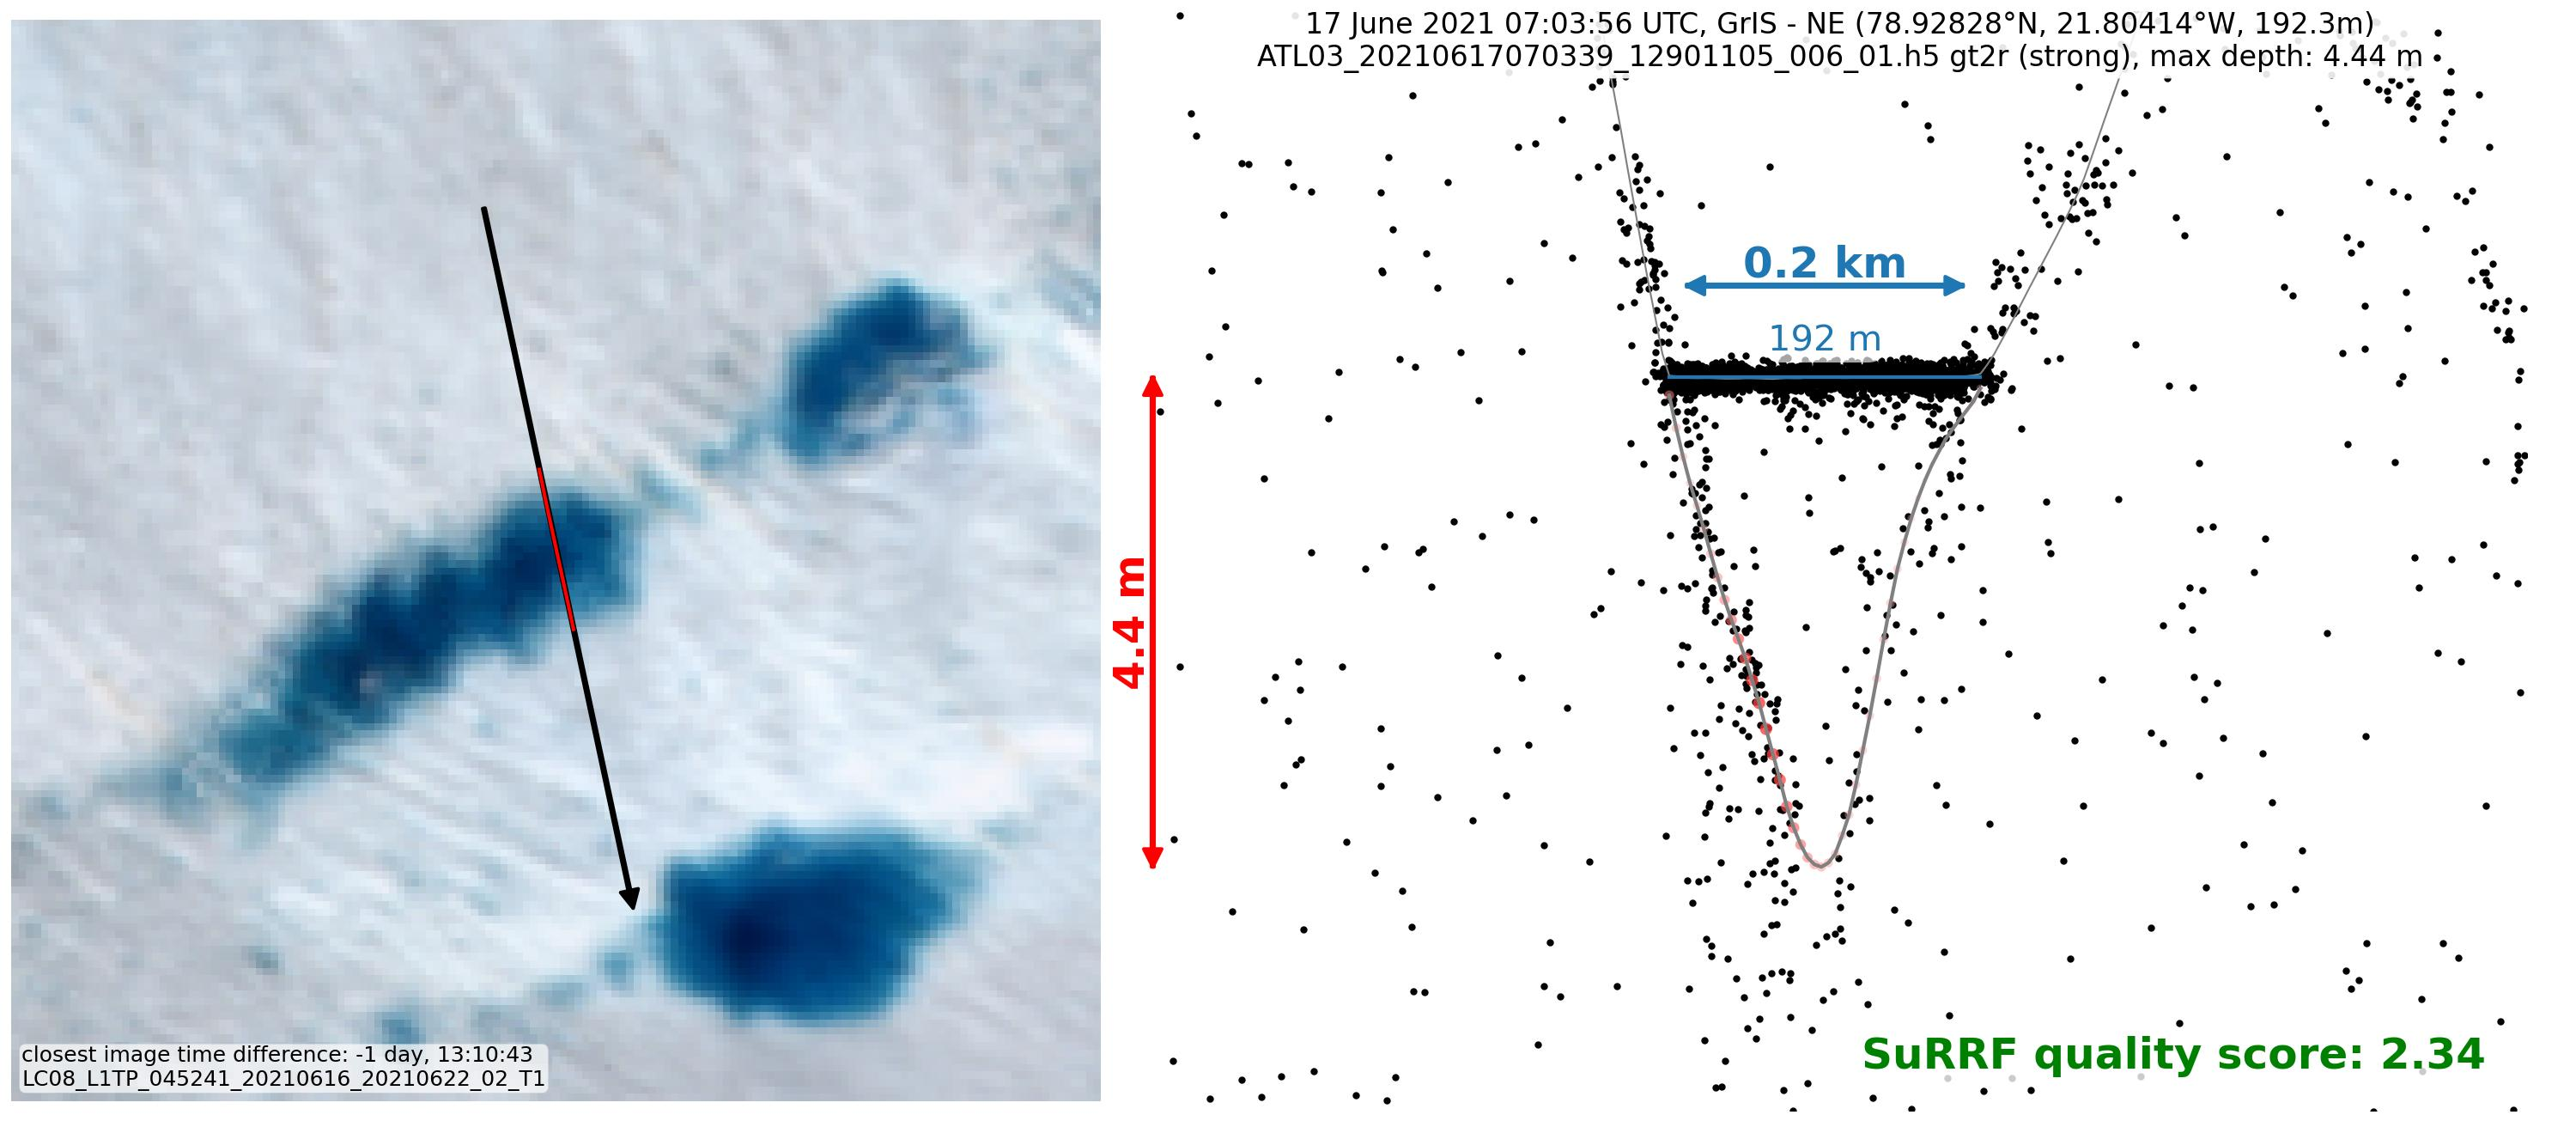

'sonar/IS2/Sonar_2022-07-09_lake522_099766_GrIS_2021_simplified_GRE_2200_NE_ATL03_20210617070339_12901105_006_01_gt2r_0010.h5'

In [164]:
lk_sel = 3108
id = lks_within.loc[lk_sel].lake_id
label = lks_within.loc[lk_sel].label
fn_ql = '../GLD3_complete/GrIS/detection_context/%s/%s_context.jpg' % (label, id)
fn_h5 = '../GLD3_complete/GrIS/detection_out_data/%s/%s.h5' % (label, id)
print(fn_ql)
print(fn_h5)
path_out = 'sonar/IS2'
fn_ql_copy = path_out + fn_ql.split('/')[-1].replace('lake_','/%s_' % fn[fn.rfind('Sonar_'):fn.rfind('_bbox_')])
fn_h5_copy = path_out + fn_h5.split('/')[-1].replace('lake_','/%s_' % fn[fn.rfind('Sonar_'):fn.rfind('_bbox_')])
print(fn_ql_copy)
print(fn_h5_copy)
display(Image(fn_ql))
# shutil.copy(fn_ql, fn_ql_copy)
# shutil.copy(fn_h5, fn_h5_copy)

In [168]:
fn = 'sonar/bbox_shapefiles/Sonar_2022-07-09_lake610b_bbox_buff_1091.shp'
gdfs = gpd.read_file(fn).to_crs(gdfp.crs).buffer(1000)
gdfs.exterior.plot(ax=ax, color='C2')
lks_within = gdfp[gdfp.within(gdfs.geometry.iloc[0])]
lks_within

,lake_id,label,ice_sheet,melt_season,date_time,lon,lat,surface_elevation,depth_quality_sort,max_depth,...,conf_q90,length_water,total_length,depth_mean,depth_median,ratio_water,geometry,basin,sub_basin,glacier_type
2115,lake_099624_GrIS_2020_simplified_GRE_2200_NE_A...,good_lake,GrIS,2020,2020-06-19T00:24:35Z,-22.011183,78.871621,245.021207,3.758562,6.710472,...,0.770134,390.0,390.0,2.989694,2.638781,0.477707,POINT (472238.526 -1113128.279),NE,ZACHARIAE_ISSTROM,tidewater
2215,lake_099641_GrIS_2019_simplified_GRE_2200_NE_A...,good_lake,GrIS,2019,2019-06-21T17:45:23Z,-22.011814,78.871192,247.555856,3.589591,3.186744,...,0.845590,270.0,270.0,1.905831,2.052988,0.413534,POINT (472244.596 -1113176.676),NE,ZACHARIAE_ISSTROM,tidewater
8064,lake_099982_GrIS_2021_simplified_GRE_2200_NE_A...,lake_bad_depth,GrIS,2021,2021-06-17T07:03:57Z,-22.011171,78.871767,240.201185,0.180542,3.210563,...,0.348435,285.0,285.0,2.265161,2.507320,0.255814,POINT (472232.571 -1113113.547),NE,ZACHARIAE_ISSTROM,tidewater


../GLD3_complete/GrIS/detection_context/good_lake/lake_099624_GrIS_2020_simplified_GRE_2200_NE_ATL03_20200619002417_12900705_006_01_gt3l_0027_context.jpg
../GLD3_complete/GrIS/detection_out_data/good_lake/lake_099624_GrIS_2020_simplified_GRE_2200_NE_ATL03_20200619002417_12900705_006_01_gt3l_0027.h5
sonar/IS2/Sonar_2022-07-09_lake610b_099624_GrIS_2020_simplified_GRE_2200_NE_ATL03_20200619002417_12900705_006_01_gt3l_0027_context.jpg
sonar/IS2/Sonar_2022-07-09_lake610b_099624_GrIS_2020_simplified_GRE_2200_NE_ATL03_20200619002417_12900705_006_01_gt3l_0027.h5


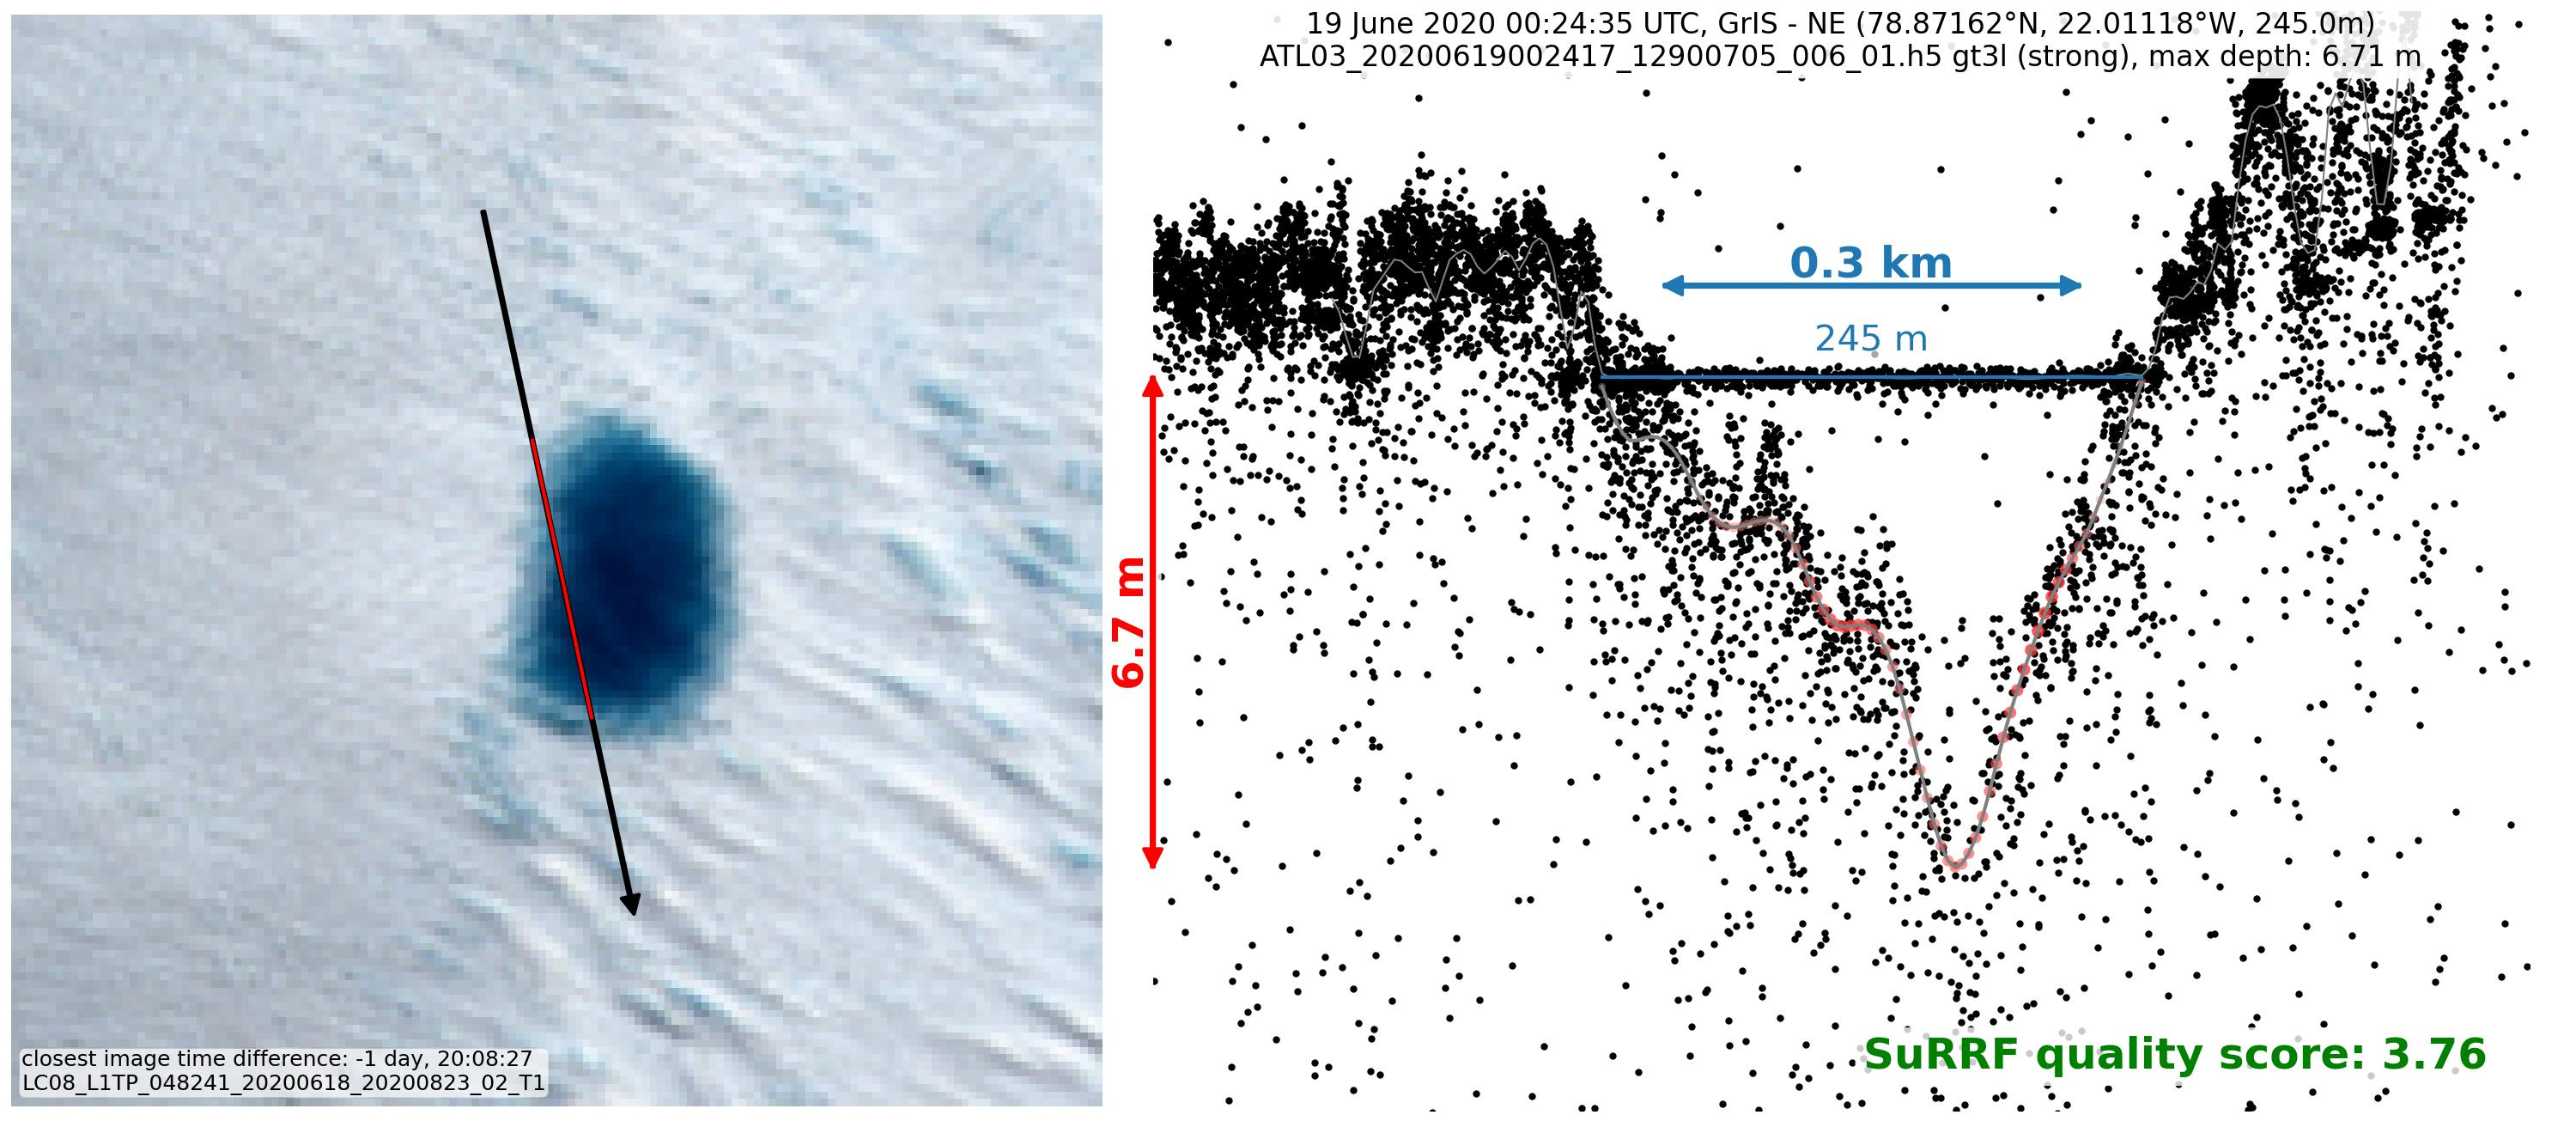

In [171]:
lk_sel = 2115
id = lks_within.loc[lk_sel].lake_id
label = lks_within.loc[lk_sel].label
fn_ql = '../GLD3_complete/GrIS/detection_context/%s/%s_context.jpg' % (label, id)
fn_h5 = '../GLD3_complete/GrIS/detection_out_data/%s/%s.h5' % (label, id)
print(fn_ql)
print(fn_h5)
path_out = 'sonar/IS2'
fn_ql_copy = path_out + fn_ql.split('/')[-1].replace('lake_','/%s_' % fn[fn.rfind('Sonar_'):fn.rfind('_bbox_')])
fn_h5_copy = path_out + fn_h5.split('/')[-1].replace('lake_','/%s_' % fn[fn.rfind('Sonar_'):fn.rfind('_bbox_')])
print(fn_ql_copy)
print(fn_h5_copy)
display(Image(fn_ql))
# shutil.copy(fn_ql, fn_ql_copy)
# shutil.copy(fn_h5, fn_h5_copy)

In [103]:
'sonar/bbox_shapefiles/Sonar_2022-07-09_lake522_bbox_buff_1290.shp'
'sonar/bbox_shapefiles/Sonar_2022-07-09_lake610b_bbox_buff_1091.shp'

,lake_id,label,ice_sheet,melt_season,date_time,lon,lat,surface_elevation,depth_quality_sort,max_depth,...,conf_q90,length_water,total_length,depth_mean,depth_median,ratio_water,geometry,basin,sub_basin,glacier_type
0,lake_000000_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,GrIS,2019,2019-08-18T03:49:28Z,-49.895976,70.437430,863.975706,3.414623e+14,11.845931,...,0.881645,190.0,190.0,8.857334,9.038176,0.317073,POINT (-182570.637 -2131353.286),CW,STORE_GLETSCHER,tidewater
1,lake_086015_GrIS_2019_simplified_GRE_2200_CE_A...,good_lake,GrIS,2019,2019-08-01T03:14:32Z,-29.452426,72.077225,1576.515319,1.398473e+02,8.264746,...,0.953027,360.0,360.0,5.463883,5.645384,0.467949,POINT (524517.511 -1885268.990),CE,CHARCOT,tidewater
2,lake_086112_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,GrIS,2019,2019-08-14T03:57:44Z,-48.989571,70.329607,1440.634057,1.388842e+02,4.654427,...,0.989059,610.0,610.0,3.056169,3.253488,0.600000,POINT (-149667.695 -2145960.954),CW,SERMEQ_AVANNARLEQ2,tidewater
3,lake_089978_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,GrIS,2019,2019-08-14T03:57:22Z,-48.429319,68.981759,1185.275591,1.002200e+02,13.051067,...,0.936802,1550.0,1550.0,8.801961,9.312227,0.787342,POINT (-137681.131 -2297577.567),CW,JAKOBSHAVN_ISBRAE,tidewater
4,lake_091049_GrIS_2019_simplified_GRE_2200_CW_A...,good_lake,GrIS,2019,2019-08-14T03:57:22Z,-48.431568,68.981906,1185.287005,8.950596e+01,12.472857,...,0.968607,1580.0,1580.0,8.292133,9.113540,0.810742,POINT (-137770.357 -2297555.766),CW,JAKOBSHAVN_ISBRAE,tidewater
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8781,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,lake_bad_depth,GrIS,2023,2023-08-10T06:24:01Z,-47.414714,62.403165,1923.015047,0.000000e+00,0.000000,...,0.035883,50.0,50.0,1.633294,1.634690,0.047414,POINT (-128348.463 -3043619.143),SW,UKAASORSUAQ,tidewater
8782,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,lake_bad_depth,GrIS,2023,2023-08-19T18:30:07Z,-47.991343,63.598828,2077.807601,0.000000e+00,0.000000,...,0.064884,0.0,NaN,NaN,NaN,0.000000,POINT (-151838.997 -2905660.717),SW,SERMEQ-KANGAASARSUUP,land_terminating
8783,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,lake_bad_depth,GrIS,2023,2023-08-19T18:30:01Z,-47.908601,63.945830,2060.941824,0.000000e+00,0.000000,...,0.032632,0.0,0.0,0.001750,0.001750,0.003546,POINT (-145635.807 -2866377.588),SW,KANGIATA_NUNAATA_SERMIA,tidewater
8784,lake_100000_GrIS_2023_simplified_GRE_2200_SW_A...,lake_bad_depth,GrIS,2023,2023-08-19T18:29:59Z,-47.939633,64.079196,1975.356456,0.000000e+00,0.000000,...,0.042076,145.0,145.0,0.243763,0.256994,0.031579,POINT (-146409.425 -2851131.789),SW,KANGIATA_NUNAATA_SERMIA,tidewater
